<a href="https://www.kaggle.com/code/rosamundl/gtsrb-image-classification?scriptVersionId=140922907" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Contributed by :** [Rosamund Lim ](https://www.linkedin.com/in/rosamund-lim/)

# Summary

**Background:** The German Traffic Sign Benchmark (GTSRB) is a multi-class, single-image classification challenge, read more [here](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign) at the dataset page. 

**Dataset:** There are 43 classes in total, and more than over 50,000 images. There are 39,209 training examples, 12,630 test examples. 

**EDA**: The classes are imbalanced, for instance, there are way more training examples for "Speed Limit 50 km/h" than for the "dangerous curve left" category. Training images are blurry and many of them are in low light conditions.

**Approach**: i) To address low quality images, increase the contrast of the images, thanks to the suggestion in this article by [Thomas Tracey](http://medium.com/@thomastracey/recognizing-traffic-signs-with-cnns-23a4ac66f7a7) ii) To address class imbalance, include class weights in the model fitting process iii) Implement transfer learning using the EfficientNetV2S architecture which touts  faster training speed and better parameter efficiency than previous models ([source](https://arxiv.org/abs/2104.00298)). 

**Results**: weighted-averaged F1 score of 99% on validation set. weighted-averaged F1 score of 98% on test set. 

# Loading Libraries and Class Labels

In [1]:
#importing libraries
import os
import random
from tqdm import tqdm
from typing import List

from PIL import Image
from skimage import exposure

import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report

import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
#classes labels represented in dictionary
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons'
          }

# Exploring Training Dataset

In [3]:
#creating filepath variables 
directory = '/kaggle/input/gtsrb-german-traffic-sign'
train_path = os.path.join(directory,'Train')
meta_path = os.path.join(directory,'Meta')
test_path = os.path.join(directory,'Test')

In [4]:
#observe the distribution of images across classes in the training set
subfolders = os.listdir(train_path)
image_count = []
class_label = []

for folder in subfolders:
    #count number of image files in each directory
    count = len(os.listdir(os.path.join(train_path, folder)))  
    image_count.append(count)
    class_label.append(classes[int(folder)])

frequency_df = pd.DataFrame({'class':class_label,
                            'frequency': image_count}
                           ).sort_values(by='frequency')

frequency_df

,class,frequency
2,Dangerous curve left,210
20,Speed limit (20km/h),210
39,Go straight or left,210
12,End of no passing,240
16,End no passing veh > 3.5 tons,240
14,End speed + passing limits,240
11,Pedestrians,240
41,Bicycles crossing,270
42,Road narrows on the right,270
13,Keep left,300


We can see from the dataframe above that the classes in the training set are imbalanced. i.e. there are many more images from the *"Speed limit (50km/h)"* category compared to the *"Dangerous curve left"* category. We will now visualise the above dataframe with a barchart

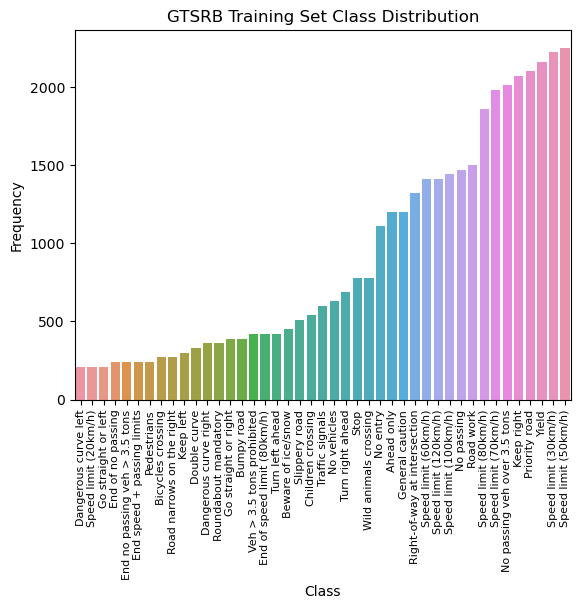

In [5]:
# Create a bar chart using Seaborn
sns.barplot(x=frequency_df['class'], y=frequency_df['frequency'])

# Add labels and title
plt.xlabel('Class')
plt.xticks(rotation='vertical',fontsize=8)
plt.ylabel('Frequency')
plt.title('GTSRB Training Set Class Distribution')

# Show the plot
plt.show()

Now, we will visualize random images from the training set folder

In [6]:
#create function to get all image paths
def get_image_paths(filepath: str) -> List[str]:
    '''takes in filepath and returns a list of filepath of all images'''
    image_paths = []
    class_labels = []
    for root,subfolders,files in os.walk(train_path):
        for filename in files:
            image_paths.append(os.path.join(root, filename))
            class_labels.append(re.findall(r'\d+',root)[0])
            
    return image_paths, class_labels

#unpack the image paths and class labels for training set
train_image_paths, train_labels = get_image_paths(train_path)

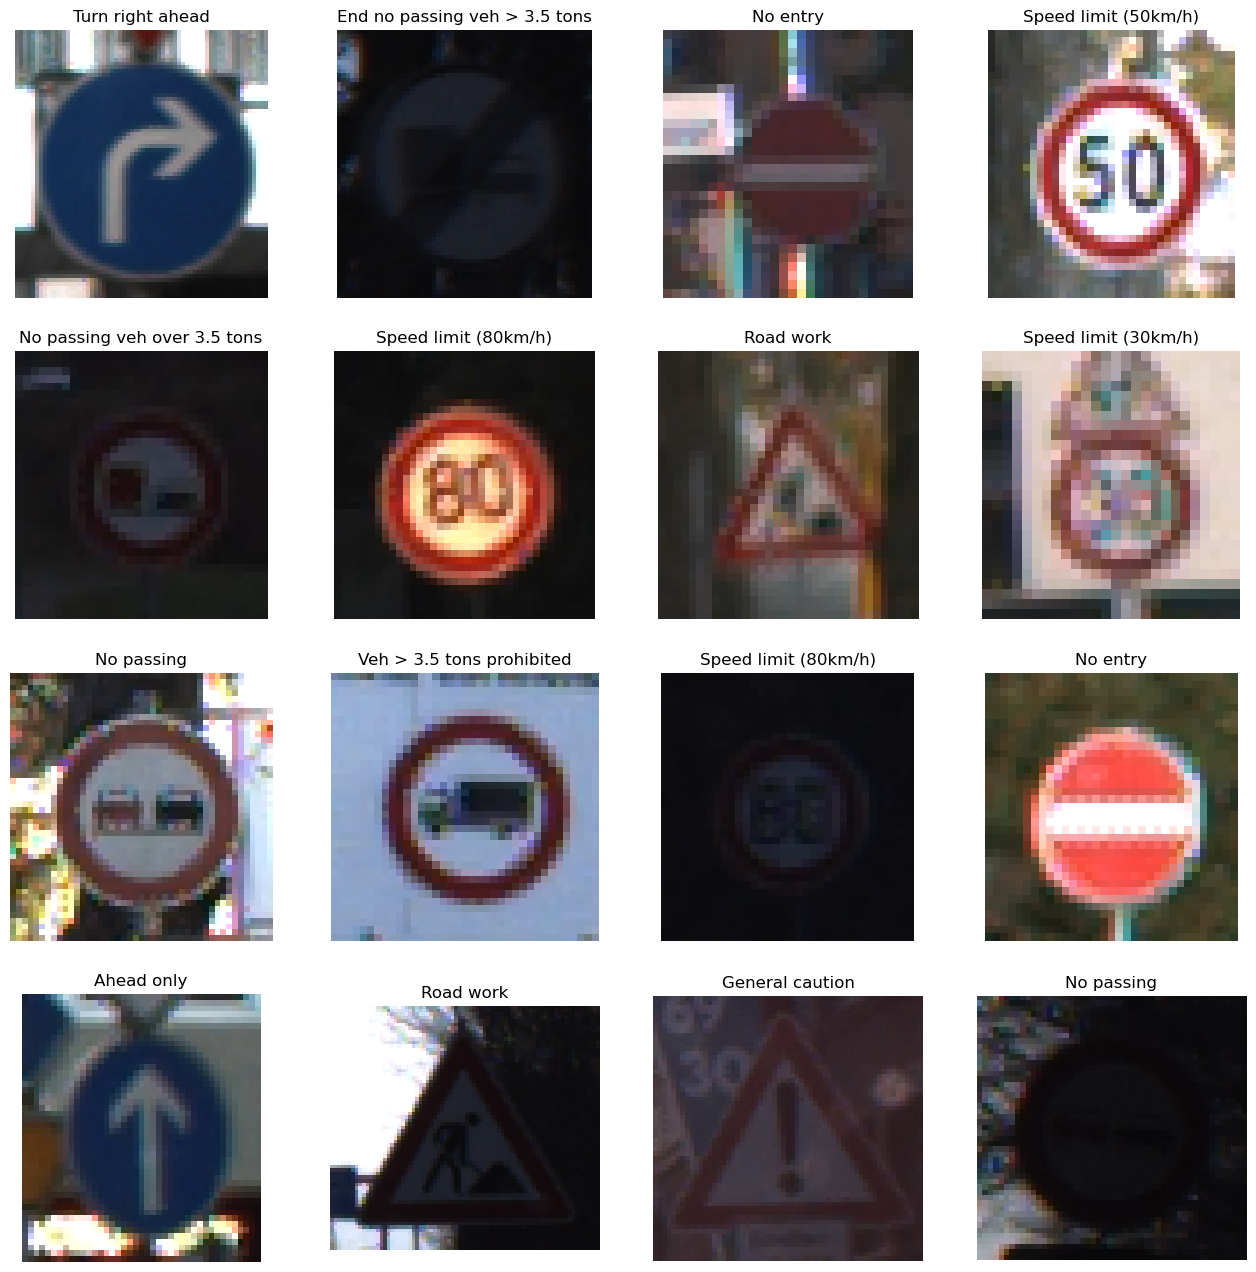

In [7]:
num_draws = 16
random_draws = random.sample(list(range(1,len(train_labels)+1)),16)

plt.figure(figsize=(16,16))

for i in range(1,17):
    plt.subplot(4,4,i)
    random_index = random_draws[i-1]
    image = imread(train_image_paths[random_index])
    plt.imshow(image)
    plt.title(classes[int(train_labels[random_index])])
    plt.axis("off")

# Loading the images into numpy array

In [8]:
train_images = []

for filepath in tqdm(train_image_paths):
    image = Image.open(filepath)
    #resize it to 32 by 32 
    image = image.resize((32,32),Image.LANCZOS) 
    image = np.array(image).astype(np.uint8)
    #sharpen contrast
    image = exposure.equalize_adapthist(image, clip_limit=0.1) 
    #rescale back by 255 
    image = (image * 255).astype(np.uint8)
    #append the data to images_numpy 
    train_images.append(image)

100%|██████████| 39209/39209 [10:36<00:00, 61.57it/s]


In [9]:
train_images = np.array(train_images)

**Below, let's sample the images again after preprocessing was done to heighten the contrast of the images**

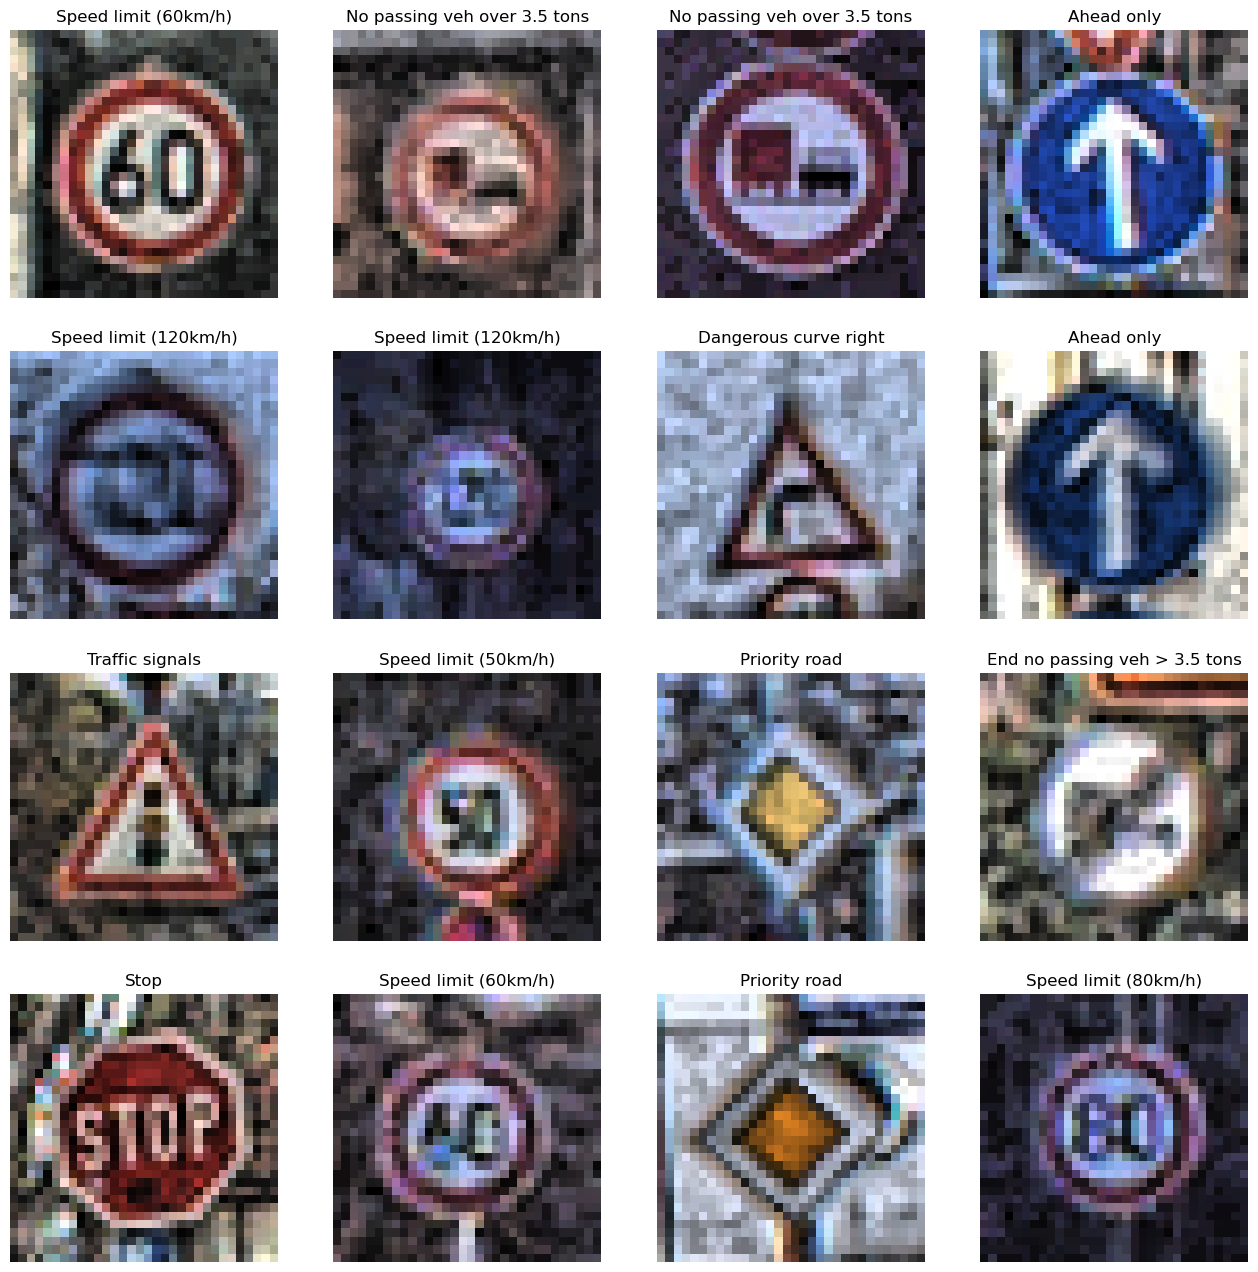

In [10]:
num_draws = 16
random_draws = random.sample(list(range(1,len(train_labels)+1)),16)

plt.figure(figsize=(16,16))

for i in range(1,17):
    plt.subplot(4,4,i)
    random_index = random_draws[i-1]
    image = train_images[random_index]
    plt.imshow(image)
    plt.title(classes[int(train_labels[random_index])])
    plt.axis("off")

**Below, we verify the shape of the train images and labels. Going forth we will split this dataset into the training and validation set.**

In [11]:
train_labels = np.array(train_labels)
print("shape of train_images:",train_images.shape)
print("shape of train_labels:",train_labels.shape)

shape of train_images: (39209, 32, 32, 3)
shape of train_labels: (39209,)


# Split into training and validation

In [12]:
x_train, x_val, y_train, y_val = train_test_split(train_images,train_labels,
                                                 test_size=0.2,random_state=42,
                                                 shuffle=True)

print("X_train.shape", x_train.shape)
print("X_valid.shape", x_val.shape)
print("y_train.shape", y_train.shape)
print("y_val.shape", y_val.shape)

X_train.shape (31367, 32, 32, 3)
X_valid.shape (7842, 32, 32, 3)
y_train.shape (31367,)
y_val.shape (7842,)


In [13]:
#class weights to handle imbalanced dataset
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                   
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights = {int(label): weight for label, weight in class_weights.items()}
class_weights

{0: 4.316361634787395,
 1: 0.41073486276974647,
 10: 0.4579190937093972,
 11: 0.6868786405640959,
 12: 0.4429053529320399,
 13: 0.4219000094153093,
 14: 1.1861221402911704,
 15: 1.4706957989497373,
 16: 2.096164127238706,
 17: 0.8298806783607164,
 18: 0.7638378180932668,
 19: 4.241076257436452,
 2: 0.4039120245177574,
 20: 2.4896420350821495,
 21: 2.8273841716243013,
 22: 2.383872929016568,
 23: 1.7922975829952574,
 24: 3.2277217534472116,
 25: 0.5964555325258134,
 26: 1.5134131043134227,
 27: 3.7028686105536535,
 28: 1.7285903229361843,
 29: 3.3615903975993997,
 3: 0.6542288038377307,
 30: 1.9985345651481363,
 31: 1.2198413315703507,
 32: 4.030194012591545,
 33: 1.286534596612116,
 34: 2.0901579263010595,
 35: 0.7702905134942658,
 36: 2.330559476929935,
 37: 4.616867824551075,
 38: 0.4285929002814746,
 39: 3.199408404732762,
 4: 0.460520906741837,
 40: 2.5959612678970454,
 41: 3.684167253934696,
 42: 3.9218554638659664,
 5: 0.47928062830425083,
 6: 2.190585934771981,
 7: 0.65364257731

In [14]:
#one hot encode the class labels
y_train = keras.utils.to_categorical(y_train, 43)
y_val = keras.utils.to_categorical(y_val,43)
print("y_train.shape", y_train.shape)
print("y_val.shape", y_val.shape)

y_train.shape (31367, 43)
y_val.shape (7842, 43)


# Building the Model (EfficientNetV2S + Transfer Learning)

In [15]:
#instantiate EfficientNetV2L
ENV2S=tf.keras.applications.EfficientNetV2S(include_top=False,
                                          weights="imagenet",
                                          input_shape=(224, 224, 3),
                                          include_preprocessing=True)

82420632/82420632 [==============================] - 1s 0us/step


In [16]:
#create upsampling layer
upsampling = tf.keras.layers.UpSampling2D(size=(7,7))
#create global average layer
global_avg = tf.keras.layers.GlobalAveragePooling2D()


In [17]:
#build trainsfer learning model
model = models.Sequential()
model.add(layers.Input(shape=(32,32,3)))
model.add(upsampling)
model.add(ENV2S)
model.add(global_avg)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(43, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                        

In [18]:
# define path for saving checkpoint
save_path = "/kaggle/working/best_weights.hdf5"
# define checkpoint 
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_path,
                                               monitor='val_accuracy',
                                               verbose=1, save_best_only=True,
                                               mode=max)
# define the conditions for early stopping
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
callbacks_list = [checkpoint,earlystop]

In [19]:
# compile the model
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
history = model.fit(x_train,y_train,
                    validation_data=(x_val, y_val),
                    epochs=10, batch_size=16, 
                    class_weight=class_weights,callbacks=callbacks_list)

Epoch 1/10
1961/1961 [==============================] - ETA: 0s - loss: 0.3224 - accuracy: 0.9154
Epoch 1: val_accuracy improved from -inf to 0.98546, saving model to /kaggle/working/best_weights.hdf5
1961/1961 [==============================] - 545s 278ms/step - loss: 0.3224 - accuracy: 0.9154 - val_loss: 0.0532 - val_accuracy: 0.9855
Epoch 2/10
1961/1961 [==============================] - ETA: 0s - loss: 0.1694 - accuracy: 0.9558
Epoch 2: val_accuracy did not improve from 0.98546
1961/1961 [==============================] - 528s 269ms/step - loss: 0.1694 - accuracy: 0.9558 - val_loss: 0.2296 - val_accuracy: 0.9510
Epoch 3/10
1961/1961 [==============================] - ETA: 0s - loss: 0.1614 - accuracy: 0.9593
Epoch 3: val_accuracy did not improve from 0.98546
1961/1961 [==============================] - 539s 275ms/step - loss: 0.1614 - accuracy: 0.9593 - val_loss: 0.0794 - val_accuracy: 0.9783
Epoch 4/10
1961/1961 [==============================] - ETA: 0s - loss: 0.1186 - accuracy:

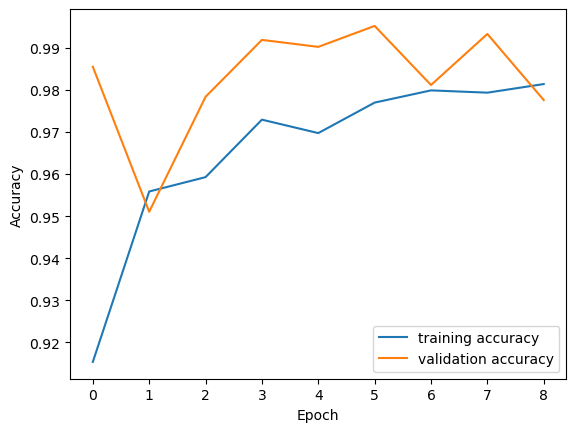

In [22]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Model Evaluation

In [23]:
#load the saved model
model.load_weights(save_path)
loss,acc = model.evaluate(x_val,y_val,verbose=2)

246/246 - 28s - loss: 0.0193 - accuracy: 0.9952 - 28s/epoch - 116ms/step


In [24]:
#classification report for the Validation Dataset
val_prob = model.predict(x_val)
#convert tests labels in single-digits instead of one-hot encoding
y_val_arg = np.argmax(y_val,axis=1)
val_predicted_labels = np.argmax(val_prob, axis = 1) #take argmax because the class with the highest probability would be the predicted class
val_report = classification_report(y_val_arg,val_predicted_labels)
print('---')
print('Classification report for Validation Dataset:')
print(val_report)

246/246 [==============================] - 30s 111ms/step
---
Classification report for Validation Dataset:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        41
           1       0.99      1.00      0.99       444
           2       1.00      0.96      0.98       444
           3       0.99      0.99      0.99       295
           4       1.00      1.00      1.00       396
           5       0.97      0.99      0.98       338
           6       1.00      1.00      1.00        87
           7       0.99      0.99      0.99       324
           8       1.00      0.98      0.99       260
           9       1.00      1.00      1.00       274
          10       1.00      1.00      1.00       417
          11       1.00      1.00      1.00       258
          12       1.00      1.00      1.00       453
          13       1.00      1.00      1.00       431
          14       1.00      0.99      1.00       165
          15       0.99    

In [25]:
#loading test images 
test = pd.read_csv(directory + '/Test.csv')

test_labels = test["ClassId"].values
test_imgs = test["Path"].values

test_data =[]

for img in tqdm(test_imgs):
    filepath = os.path.join(directory,img)
    image = Image.open(filepath)
    #resize it to 32 by 32 
    image = image.resize((32,32),Image.LANCZOS) 
    image = np.array(image).astype(np.uint8)
    #sharpen contrast
    image = exposure.equalize_adapthist(image, clip_limit=0.1) 
    #rescale back by 255 
    image = (image * 255).astype(np.uint8)
    #append the data to images_numpy 
    test_data.append(image)

100%|██████████| 12630/12630 [03:51<00:00, 54.51it/s]


In [26]:
#convert to numpy array and check the shape of the test data
test_data = np.array(test_data)
print(test_labels.shape)
print(test_data.shape)

(12630,)
(12630, 32, 32, 3)


In [27]:
#Produce classification report for the Test Dataset
test_prob = model.predict(test_data)
test_predicted_labels = np.argmax(test_prob, axis = 1) #take argmax because the class with the highest probability would be the predicted class
test_report = classification_report(test_labels,test_predicted_labels)
print('---')
print('Classification report for Test Dataset:')
print(test_report)

395/395 [==============================] - 45s 114ms/step
---
Classification report for Test Dataset:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        60
           1       0.99      1.00      1.00       720
           2       1.00      0.98      0.99       750
           3       0.98      0.98      0.98       450
           4       1.00      0.99      0.99       660
           5       0.94      0.99      0.96       630
           6       0.99      0.97      0.98       150
           7       0.99      0.99      0.99       450
           8       1.00      0.92      0.96       450
           9       1.00      0.99      0.99       480
          10       0.99      0.99      0.99       660
          11       0.99      0.99      0.99       420
          12       1.00      0.99      0.99       690
          13       0.98      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       0.99      1.00